In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math as math
import PySulfSat as ss
import matplotlib as mpl
import periodictable as pt
import seaborn as sb
import sulfur as sf
import matplotlib as mpl

def S6_total_OandM(composition, T_C, del_FMQ):
    T_K = T_C + 273.15
    """o2: log10"""
    wtsio2 = composition["SiO2_liq_mage"]
    wttio2 = composition["TiO2_liq_mage"]
    wtal2o3 = composition["Al2O3_liq_mage"]
    wtfeo = composition["FeO_liq_mage"]
    wtmno = composition["MnO_liq_mage"]
    wtmgo = composition["MgO_liq_mage"]
    wtcao = composition["CaO_liq_mage"]
    wtna2o = composition["Na2O_liq_mage"]
    wtk2o = composition["K2O_liq_mage"]
    wtp2o5 = composition["P2O5_liq_mage"]

    xtot = wtsio2/60.08+wttio2/79.9+wtal2o3/50.98+wtfeo/71.85+wtmgo/40.32+ wtcao/56.08+wtna2o/30.99+wtk2o/47.1+wtmno/70.94
    
    xna = (wtna2o/30.99)/xtot
    xmg = (wtmgo/40.32)/xtot
    xal = (wtal2o3/50.98)/xtot
    xsi = (wtsio2/60.08)/xtot
    xk = (wtk2o/47.1)/xtot
    xca = (wtcao/56.08)/xtot
    xti = (wttio2/79.9)/xtot
    xmn = (wtmno/70.94)/xtot
    xfet = (wtfeo/71.85)/xtot
    fe2_fetotal = 1/(1 + 10**(0.25*del_FMQ - 1.36 + 2.4*xca + 2*xna + 3.7*xk))
    xferrous = xfet * fe2_fetotal
    fo2 = del_FMQ - 25050/T_K+8.5
    
    c_sulfide = 8.77-23590/T_K+(1673/T_K)*(6.7*(xna+xk)+4.9*xmg+8.1*xca+8.9*(xfet+xmn)+5*xti+1.8*xal
                                                   -22.2*xti*(xfet+xmn)+7.2*((xfet+xmn)*xsi))-2.06*erf(-7.2*(xfet+xmn))
    c_sulfate = (-8.02) +(21100+44000*xna+18700*xmg+4300*xal+35600*xca+44200*xk+16500*xferrous+12600*xmn)/T_K
    lnk = (-55921)/T_K+25.07-0.6465*np.log(T_K) # SO3/S
    lnrs =(c_sulfate - lnk - c_sulfide) + 2 * np.log(10)*fo2
    rs =1-1/(1+np.exp(lnrs))

    return rs

def calc_melt_comp(Co, D, F, type):
    '''
        Calculate the melt composition based on initial concentration and melting model.

    Parameters
    ----------
    Co : float
        Initial concentration of the element in the source material.
    D : float
        Bulk distribution coefficient.
    F : float
        Melt fraction (in percent, e.g., 10 for 10%).
    type : str
        Type of melting model to use. Must be one of:
        - 'EQ' for equilibrium crystallisation.
        - 'FC' for fractional crystallization.

    Returns
    -------
    Cl : float
        Concentration of the element in the melt.

    '''
    if type == 'EQ':
        Cl = (Co/(D+F/100*(1-D)))
    elif type == 'FC':
        Cl = Co*(F/100)**(D-1)
    else:
        raise ValueError("Invalid type. Must be 'EQ' or 'FC'.")
    return Cl


In [3]:
data = pd.read_csv('../data/FC_model_blatter.csv')

data['MnO_liq_mage'] = 0
data['P2O5_liq_mage'] = 0

data.iloc[:, 6:] = data.iloc[:, 6:]*100 # convert to wt%

# Delete problematic data with low melt fraction
# data = data.drop(data[data.melt_frac_wt < 10].index)

# Model setup
n_llds = len(data['simulation'].unique()) # Number of LLDs in dataframe
s_initial = np.random.uniform(1000,3000,n_llds) # initial sulfur in the melt (ppm) range (s_min, s_max, n)
Cu_initial = np.random.uniform(50,100,n_llds) # initial Cu from MORB range given in Lee et al. 
DCu_minmelt = 0.1 # partition coefficient for Cu mineral/melt
Ag_initial = np.random.uniform(0.02,0.03,n_llds) # initial Ag from Jenner Jpet
DAg_minmelt = 0.1 # partition coefficient for Cu mineral/melt
Au_initial = np.random.uniform(0.002,0.004,n_llds) # initial Au guesstimated
DAu_minmelt = 0.1 # partition coefficient for Cu mineral/melt
Pd_initial = np.random.uniform(0.007,0.02,n_llds) # given by Ariadni in an email
DPd_minmelt = 0.1
DPd_mss = np.random.uniform(7e4,5e5,n_llds) # range of Pd DMSS/melt given by Ariadni in an email
rho_mss = 4610 # density of pyrrhotite
Fe_FeNiCu_Sulf = 0.75    # Approximate the sulfide composition 

mss_sl_ratio = np.zeros(n_llds) # MSS/SL ratio
sulfide_liquidus = 1130
sulfide_solidus = 1080

llds = [data.groupby('simulation').get_group(x) for x in data.groupby('simulation').groups]

outputs = []
n = 0
for lld in llds:

    # Calculate the ratio of MSS to SL. At higher T, SL is favoured. Use the phase diagram of sulfide liquid from Bockrath et al. (2004) to approximate ratio with temperature 1130
    lld['mss_sl_ratio'] = np.where(lld['T_C'] > sulfide_liquidus, 0, 1.0) # 100% SL above liquidus
    rel_t = lld['T_C'] - sulfide_solidus  # relative temperature between solidus and liquidus'
    lld['mss_sl_ratio']  = np.where((lld['T_C'] < sulfide_liquidus) & (lld['T_C'] > sulfide_solidus), -0.02*rel_t+1, lld['mss_sl_ratio']) # Where below liquidus and solidus, interpolate between 100% SL and 100% MSS

    lld['S_melt'] = s_initial[n] * (lld['abs_melt_frac']/100)**(0-1) # Assuming sulfur is completely incompatible estimate its % increase in the melt

    # New dataframe compatibly with ss
    data_scss = lld[['SiO2_liq_mage', 'TiO2_liq_mage', 'Al2O3_liq_mage', 'FeO_liq_mage', 'MgO_liq_mage', 'CaO_liq_mage', 'Na2O_liq_mage', 'MnO_liq_mage', 'P2O5_liq_mage', 'K2O_liq_mage', 'H2O_liq_mage']]
    data_scss.columns = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'CaO_Liq', 'Na2O_Liq', 'MnO_Liq','P2O5_Liq', 'K2O_Liq', 'H2O_Liq']

    # Li & Zhang SCSS
    LZ2022_SCSS = ss.calculate_LiZhang2022_SCSS(df=data_scss,T_K=lld['T_C']+273.15, P_kbar=lld['P_kbar'], Fe_FeNiCu_Sulf=Fe_FeNiCu_Sulf, logfo2=sf.calc_logfo2(lld['T_C'], lld['delta_QFM']))
    lld['SCSS_Tot'] = LZ2022_SCSS['SCSS_Tot']

    # O'Neill and Mavrogenes S6+/Stotal
    lld['S6_total'] = sf.S6_total_OandM(composition=data_scss, T_C = lld['T_C'], del_FMQ=lld['delta_QFM'])

    # Convert bulk sulfur in melt to S2- in the melt
    lld['S2_melt'] = lld['S_melt']*(1-lld['S6_total'])

    # Sulfate content at sulfate saturation Zajacz & Tsay (2019)
    ZT2019_SCAS = ss.calculate_ZT2019_SCAS(df=data_scss, T_K=lld['T_C']+273.15)
    lld['S6_melt'] = lld['S_melt']*lld['S6_total']
    sulfate_saturated = np.where(lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm'], 'Saturated', 'Undersaturated')

    # Now we calcualte the S melt, which will be buffered by SCSS or SCAS if it sulfide or sulfate saturated
    # if sulfide saturated and not sulfate saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] < lld['S2_melt']) & (lld['S6_melt'] < ZT2019_SCAS['SCAS6_ppm']), lld['SCSS_Tot'], lld['S_melt'])
    
    # if sulfate saturated and not sulfide saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['Andyrite before Sulfide'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), 1, 0)
    
    # if both sulfide and sulfate saturated, take the sulfur content which is lowest 
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] < lld['SCSS_Tot']),
                              ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] > lld['SCSS_Tot']),
                              lld['SCSS_Tot'], lld['S_melt'])
    

    lld['mass_mss'] = (s_initial[n] * 1-lld['SCSS_Tot'] * lld['abs_melt_frac']/100)/10**6  *  pt.formula("FeS").mass/pt.formula("S").mass

    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    lld['mass_mss'] = bool*lld['mass_mss'] # boolean if sulphide is saturated
    lld['cum_mass_mss'] = np.cumsum(lld['mass_mss'])
    lld['vol_mss_sol'] = (lld['mass_mss']*100)/(rho_mss/lld['density_solid'])
    lld['vol_mss_liq'] = (lld['mass_mss']*100)/(rho_mss/lld['density_liquid'])
    lld['cum_vol_mss_sol'] = np.cumsum(lld['vol_mss_sol'])
    
    # Calculate MSS/melt partition coefficients
    DCu_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Cu', sulfur_phase = 'MSS')
    DAu_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Au', sulfur_phase = 'MSS')
    DAg_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Ag', sulfur_phase = 'MSS')

    # Calculate SL/melt partition coefficients (sulfide liquid)
    DCu_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Cu', sulfur_phase = 'SL')
    DAu_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Au', sulfur_phase = 'SL')
    DAg_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Ag', sulfur_phase = 'SL')

    lld['mss_sl_ratio'] = lld['mss_sl_ratio']*bool # Only when sulfide is saturated

    # Calculate bulk partition coefficients for MSS and SL
    DCu_S = (DCu_MSS * lld['mss_sl_ratio']) + (DCu_SL * (1 - lld['mss_sl_ratio']))
    DAu_S = (DAu_MSS * lld['mss_sl_ratio']) + (DAu_SL * (1 - lld['mss_sl_ratio']))
    DAg_S = (DAg_MSS * lld['mss_sl_ratio']) + (DAg_SL * (1 - lld['mss_sl_ratio']))

    # Calculate bulk partition coefficient
    D_Cu = DCu_minmelt * (100 - lld['abs_melt_frac']) / 100 + DCu_S * lld['mass_mss']
    D_Au = DAu_minmelt * (100 - lld['abs_melt_frac']) / 100 + DAu_S * lld['mass_mss']
    D_Ag = DAg_minmelt * (100 - lld['abs_melt_frac']) / 100 + DAg_S * lld['mass_mss']
    
    # Calculate melt composition using Rayliegh FC
    lld['Cu_melt'] = sf.calc_melt_comp(Cu_initial[n], D_Cu, lld['abs_melt_frac'], 'FC')
    lld['Au_melt'] = sf.calc_melt_comp(Au_initial[n], D_Au, lld['abs_melt_frac'], 'FC')
    lld['Ag_melt'] = sf.calc_melt_comp(Ag_initial[n], D_Ag, lld['abs_melt_frac'], 'FC')

    outputs.append(lld)
    n = n + 1
data_sulf = pd.concat(outputs, axis=0, ignore_index=True)

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
r

In [4]:
data_sulf['Mg#_sol'] = ((1/40.32)*data_sulf['MgO_sol_mage'])/(((0.9/79.8)*data_sulf['FeO_sol_mage'])+((1/40.32)*data_sulf['MgO_sol_mage']))
data_sulf['Mg#_liq'] = ((1/40.32)*data_sulf['MgO_liq_mage'])/(((0.9/79.8)*data_sulf['FeO_liq_mage'])+((1/40.32)*data_sulf['MgO_liq_mage']))


llds = [data_sulf.groupby('simulation').get_group(x) for x in data_sulf.groupby('simulation').groups]

ss_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
ss_mgsol = np.zeros(len(llds)) # Empty list of Mg# of solid at sulfide saturation
dqfm = np.zeros(len(llds))
ss_sio2 = np.zeros(len(llds))
ss_melt_frac = np.zeros(len(llds))
ss_T = np.zeros(len(llds)) # Empty list of T at sulfide saturation
sa_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
sa_mgsol = np.zeros(len(llds)) # Empty list of Mg# of solid at anhydrite saturation
sa_sio2 = np.zeros(len(llds))
sa_melt_frac = np.zeros(len(llds))
sa_T = np.zeros(len(llds)) # Empty list of T at anhydrite saturation
P = np.zeros(len(llds)) # Empty list of P

n = 0
for lld in llds:
    
    lld = lld.reset_index(drop=True)
    # Store the point at which sulfide saturates 
    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    if 1 in bool:
        ss_index = list(bool).index(1)
        ss_mg[n] = lld['Mg#_liq'].iloc[ss_index]
        ss_mgsol[n] = lld['Mg#_sol'].iloc[ss_index]
        ss_sio2[n] = lld['SiO2_liq_mage'].iloc[ss_index]
        ss_melt_frac[n] = lld['abs_melt_frac'].iloc[ss_index]
        ss_T[n] = lld['T_C'].iloc[ss_index]
    else:
        ss_index = 'Undersaturated'
        ss_mg[n] = 0 # If you never saturate in sulfide use 0
        ss_mgsol[n] = 0
        ss_sio2[n] = 0 # If you never saturate in sulfide use 0
        ss_melt_frac[n] = 0 
        ss_T[n] = 0
    dqfm[n] = lld['delta_QFM'].iloc[0]
    P[n] = lld['P_kbar'].iloc[0]

    # Store the point at which anydrite saturates
    bool2 =  lld['Andyrite before Sulfide']
    if 1 in bool2.values:
        sa_index = list(bool2.astype(int)).index(1)
        sa_mg[n] = lld['Mg#_liq'].iloc[sa_index]
        sa_mgsol[n] = lld['Mg#_sol'].iloc[sa_index]
        sa_sio2[n] = lld['SiO2_liq_mage'].iloc[sa_index]
        sa_melt_frac[n] = lld['abs_melt_frac'].iloc[sa_index]
        sa_T[n] = lld['T_C'].iloc[sa_index]

    else:
        sa_index = 'Undersaturated'
        sa_mg[n] = 0 # If you never saturate in sulfide use 0
        sa_mgsol[n] = 0
        sa_sio2[n] = 0 # If you never saturate in sulfide use 0
        sa_melt_frac[n] = 0 
        sa_T[n] = 0
        
    n = n + 1

ss_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(ss_sio2, name = 'SiO2 at SS'), pd.Series(ss_mg, name = '#Mg Liq at SS'),
                   pd.Series(s_initial, name = "Initial S"), pd.Series(ss_melt_frac, name = 'Melt Fraction'), pd.Series(ss_T, name = 'Temperature'), pd.Series(P, name = 'P (kbar)')], axis = 1)

sa_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(sa_sio2, name = 'SiO2 at SS'), 
                   pd.Series(s_initial, name = "Initial S"), pd.Series(sa_melt_frac, name = 'Melt Fraction'), pd.Series(sa_T, name = 'Temperature'), pd.Series(P, name = 'P (kbar)')], axis = 1)

ss_df = ss_df.dropna()
sa_df = sa_df.dropna()

In [8]:
# Whole rock Cu data for arcs

lt_df = pd.read_csv('../data/Lee_Tang_Appendix.csv')
lt_df = lt_df[lt_df['Cu'].notna()]

# Create 4% bins for SiO2
bin_edges = np.arange(45, 75+2, 2)  # Define bin edges
lt_df['SiO2_bins'] = pd.cut(lt_df['SiO2'], bins=bin_edges)

# Group by bins and calculate the average Cu values
binned_data_mean = lt_df.groupby('SiO2_bins')['Cu'].mean().reset_index()
binned_data_lq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.05).reset_index()
binned_data_uq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.95).reset_index()

# Extract bin labels and averages
bin_labels = binned_data['SiO2_bins'].astype(str)  # Bin ranges as strings
average_cu_all = binned_data_mean['Cu']

x = (bin_edges+1)[:-1]

/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_14011/3764935566.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_mean = lt_df.groupby('SiO2_bins')['Cu'].mean().reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_14011/3764935566.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_lq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.05).reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_14011/3764935566.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_14011/2928840581.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'best', framealpha = 0)
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_14011/2928840581.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'best', framealpha = 0)


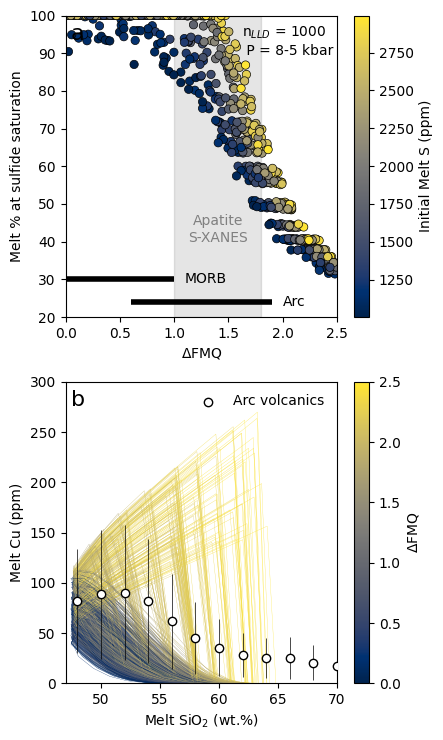

In [9]:
from matplotlib import colors
from matplotlib import cm
norm = colors.Normalize(vmin=s_initial.min(), vmax=s_initial.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
cmap.set_array([])

fig, axs = plt.subplots(2,1, figsize = (4.5,7.5))

axs[0].axvspan(1.4-0.4, 1.4+0.4, color="black", alpha=0.1)

sb.scatterplot(x=ss_df['dQFM'], y=ss_df['Melt Fraction'], edgecolor = 'black', c  = cmap.to_rgba(ss_df["Initial S"]), ax = axs[0])
axs[0].set_xlabel('$\Delta$FMQ')
axs[0].set_ylabel('Melt % at sulfide saturation')

norm = plt.Normalize(s_initial.min(), s_initial.max())
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])

axs[0].figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = axs[0])

# Color scale
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

for lld in llds:
    axs[1].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])
axs[1].figure.colorbar(sm, label = '$\Delta$FMQ', ax = axs[1])

axs[1].set_ylabel('Melt Cu (ppm)')
axs[1].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[1].set_ylim([0, 300])
axs[0].set_ylim([20,100])
axs[0].set_xlim([0.0, 2.5])
axs[1].set_xlim([47,70])

axs[0].hlines(24, 0.6, 1.9, color = 'black', linewidth = 4)
axs[0].hlines(30, 0, 1.0, color = 'black', linewidth = 4)

axs[0].annotate(xy = (1.1, 29), text = 'MORB', color = 'black')
axs[0].annotate(xy = (2.0, 23), text = 'Arc', color = 'black')

axs[0].annotate(xy = (1.4, 40), text = 'Apatite\nS-XANES', color = 'gray', horizontalalignment = 'center')

axs[1].annotate(xy = (1.4, 5), text = 'Arc', color = 'black')
axs[1].legend(loc = 'best', framealpha = 0)

axs[1].legend(loc = 'best', framealpha = 0)

axs[1].errorbar(x= x, y = average_cu_all, yerr = average_cu_all-binned_data_lq['Cu'], zorder = 100,color = 'black', linewidth = 0.5, ls = 'none')
axs[1].scatter(x, average_cu_all, zorder = 100, color = 'white', edgecolor = 'black', label = 'Arc volcanics')

axs[0].annotate(xy = (0.02, 0.92), text = 'a', fontsize = 16, xycoords = 'axes fraction')
axs[1].annotate(xy = (0.02, 0.92), text = 'b', fontsize = 16, xycoords = 'axes fraction')


axs[0].annotate(xy = (0.65,0.87), text = 'n$_{LLD}$ = %1d \n P = %1d-%1d kbar' % (len(llds), data['P_kbar'].max(), round(data['P_kbar'].min())), xycoords = 'axes fraction')

axs[1].legend(loc = 'upper right', framealpha = 0)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../outputs/SiO2_at_SS.png', dpi = 1200)
plt.show()

Text(0, 0.5, 'Melt Pct at sulfide saturation')

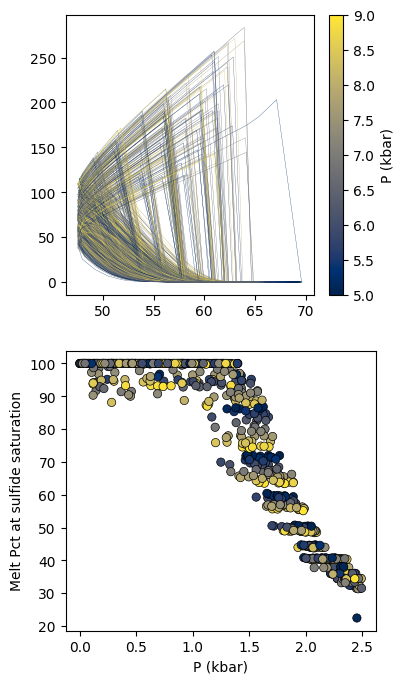

In [9]:
fig, axs = plt.subplots(2,1, figsize=(4,8))

# Color scale
norm = mpl.colors.Normalize(vmin=data['P_kbar'].min(), vmax=data['P_kbar'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

for lld in llds:
    axs[0].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['P_kbar'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['P_kbar'].min(),1), vmax=round(data['P_kbar'].max(),1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])
axs[1].figure.colorbar(sm, label = 'P (kbar)', ax = axs[0])

norm = colors.Normalize(vmin=5, vmax=9)
cmap = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
cmap.set_array([])

sb.scatterplot(x=ss_df['dQFM'], y=ss_df['Melt Fraction'],c  = cmap.to_rgba(ss_df["P (kbar)"]), edgecolor = 'black', ax = axs[1])
axs[1].set_xlabel('P (kbar)')
axs[1].set_ylabel('Melt Pct at sulfide saturation')


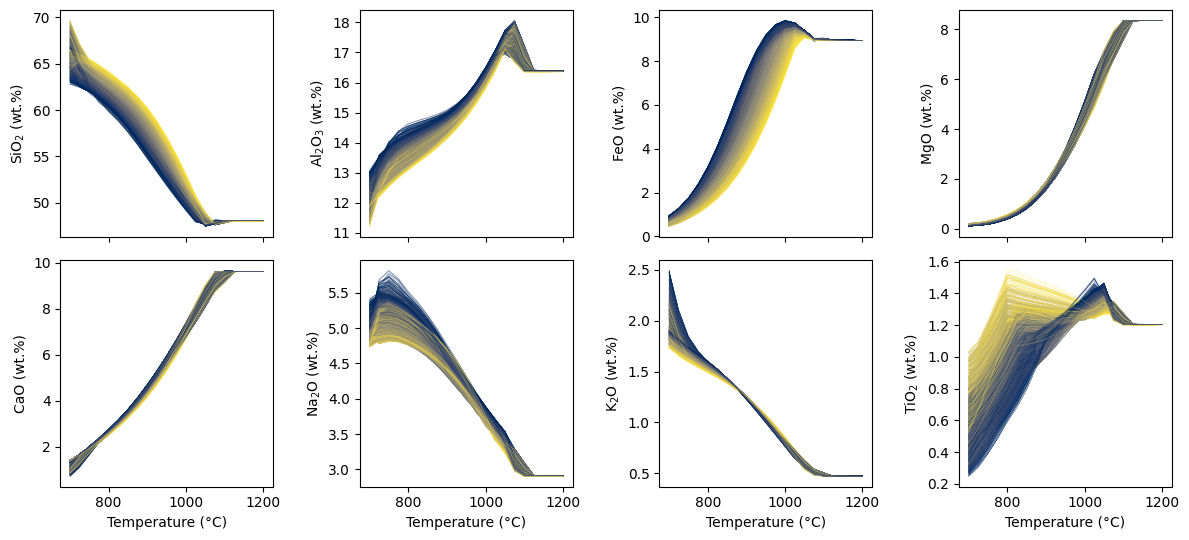

In [10]:
fig, axs = plt.subplots(2,4, figsize=(12,5.5), sharex=True)
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

axr = axs.flatten()

# Plot Harker of FeO coloured by fO2. In Chang and Audetat (2018) they say that sulfide saturation can be triggered by decreasing FeO

for lld in llds:
    axr[0].plot(lld['T_C'], lld['SiO2_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 
    axr[1].plot(lld['T_C'], lld['Al2O3_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 
    axr[2].plot(lld['T_C'], lld['FeO_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 
    axr[3].plot(lld['T_C'], lld['MgO_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)
    axr[4].plot(lld['T_C'], lld['CaO_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 
    axr[5].plot(lld['T_C'], lld['Na2O_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 
    axr[6].plot(lld['T_C'], lld['K2O_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)
    axr[7].plot(lld['T_C'], lld['TiO2_liq_mage'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)


axr[0].set_ylabel('SiO$_{2}$ (wt.%)')
axr[1].set_ylabel('Al$_{2}$O$_{3}$ (wt.%)')
axr[2].set_ylabel('FeO (wt.%)')
axr[3].set_ylabel('MgO (wt.%)')
axr[4].set_ylabel('CaO (wt.%)')
axr[5].set_ylabel('Na$_{2}$O (wt.%)')
axr[6].set_ylabel('K$_{2}$O (wt.%)')
axr[7].set_ylabel('TiO$_{2}$ (wt.%)')

axr[4].set_xlabel('Temperature (°C)')
axr[5].set_xlabel('Temperature (°C)')
axr[6].set_xlabel('Temperature (°C)')
axr[7].set_xlabel('Temperature (°C)')

plt.tight_layout()
plt.savefig('../outputs/MAGEMin_Harker.png', dpi = 1200)
plt.show()


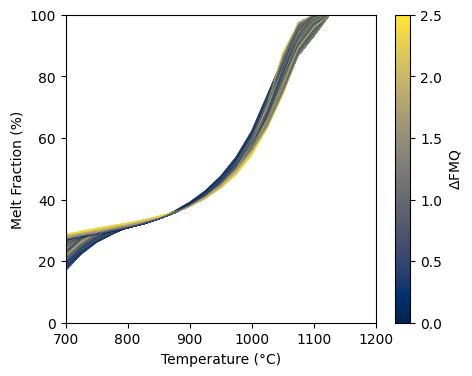

In [11]:
fig, ax = plt.subplots(figsize=(5,4))


for lld in llds:
    plt.plot(lld['T_C'], lld['abs_melt_frac'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2) 

plt.xlabel('Temperature (°C)')
plt.ylabel('Melt Fraction (%)')

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])
# sub_ax = plt.axes([0.99, 0.3, 0.02, 0.5]) # add a small custom axis
ax.figure.colorbar(sm, label = '$\Delta$FMQ', ax = ax)

plt.xlim([700, 1200])
plt.ylim([0, 100])
plt.savefig('../outputs/MAGEMin_Melt_Fraction.png', dpi = 1200)
plt.show()

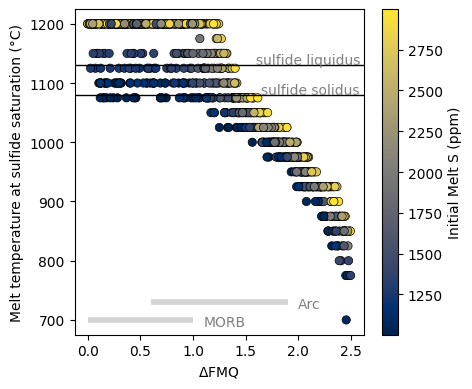

In [12]:
fig, ax = plt.subplots(figsize=(4.8,4))

norm = colors.Normalize(vmin=s_initial.min(), vmax=s_initial.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
cmap.set_array([])


sb.scatterplot(x=ss_df['dQFM'], y=ss_df['Temperature'], edgecolor = 'black', c  = cmap.to_rgba(ss_df["Initial S"]))
ax.set_xlabel('$\Delta$FMQ')
ax.set_ylabel('Melt temperature at sulfide saturation (°C)')

ax.axhline(y=1130, color = 'black', linewidth = 1)
ax.axhline(y =1080, color = 'black', linewidth = 1)

ax.hlines(730, 0.6, 1.9, color = 'lightgray', linewidth = 4)
ax.hlines(700, 0, 1.0, color = 'lightgray', linewidth = 4)

ax.annotate(xy = (1.1, 690), text = 'MORB', color = 'gray')
ax.annotate(xy = (2.0, 720), text = 'Arc', color = 'gray')

ax.annotate(xy = (1.65, 1082), text = 'sulfide solidus', color = 'gray')
ax.annotate(xy = (1.60, 1132), text = 'sulfide liquidus', color = 'gray')


norm = plt.Normalize(s_initial.min(), s_initial.max())
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])

ax.figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = ax)

plt.tight_layout()
plt.savefig('../outputs/SS_T_vs_dQFM.png', dpi = 1200)

KeyboardInterrupt: 

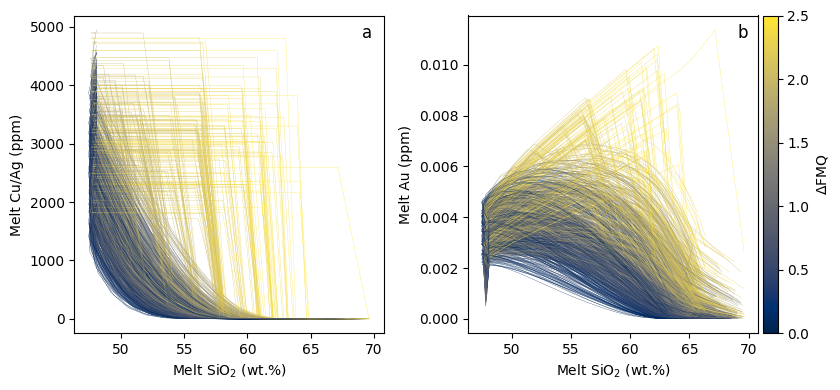

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize=(8.5, 4.0)) 

# normalization + colormap
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

# plot the lines
for lld in llds:
    axs[0].plot(lld['SiO2_liq_mage'], lld['Cu_melt']/lld['Ag_melt'],
                color=cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth=0.2)
    axs[1].plot(lld['SiO2_liq_mage'], lld['Au_melt'],
                color=cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth=0.2)

# new normalization for colorbar ticks
norm = plt.Normalize(vmin=round(data['delta_QFM'].min(), 1),
                     vmax=round(data['delta_QFM'].max(), 1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])

# ---- attach colorbar without shrinking the subplot ----
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)  # 5% width, small padding
cb = fig.colorbar(sm, cax=cax, label='$\Delta$FMQ')

# labels
axs[0].set_ylabel('Melt Cu/Ag (ppm)')
axs[1].set_ylabel('Melt Au (ppm)')
axs[0].set_xlabel('Melt SiO$_{2}$ (wt.%)')
axs[1].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[0].annotate(text = 'a', xy = (0.93, 0.93), xycoords='axes fraction', fontsize=12)
axs[1].annotate(text = 'b', xy = (0.93, 0.93), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/MAGEMin_CuAg_Au_vs_SiO2.png', dpi=1200)
plt.show()
